# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images. **Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

In [33]:
from fastai.vision import *
torch.multiprocessing.set_sharing_strategy('file_system')

## Get a list of URLs

### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

In Google Chrome press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>j</kbd> on Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>j</kbd> on macOS, and a small window the javascript 'Console' will appear. In Firefox press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>k</kbd> on Windows/Linux or <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>k</kbd> on macOS. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.

In [ ]:
folder = 'black'
file = 'urls_black.csv'

In [ ]:
folder = 'teddys'
file = 'urls_teddys.csv'

In [ ]:
folder = 'grizzly'
file = 'urls_grizzly.csv'

You will need to run this cell once per each category.

In [ ]:
folder = 'ai-generated'

In [ ]:
folder = 'real-world'

In [2]:
path = Path('data/faces/train')
#dest = path/folder
#dest.mkdir(parents=True, exist_ok=True)

In [3]:
path.ls()

[PosixPath('data/faces/train/models'),
 PosixPath('data/faces/train/ai-generated'),
 PosixPath('data/faces/train/real-world')]

Finally, upload your urls file. You just need to press 'Upload' in your working directory and select your file, then click 'Upload' for each of the displayed files.

![uploaded file](images/download_images/upload.png)

## Download images

Now you will need to download your images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

You will need to run this line once for every category.

In [34]:
classes = ['ai-generated','real-world']

In [ ]:
download_images(path/file, dest, max_pics=200)

In [ ]:
# If you have problems download, try with `max_workers=0` to see exceptions:
download_images(path/file, dest, max_pics=20, max_workers=0)

Then we can remove any images that can't be opened:

In [19]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

ai-generated


real-world


## View data

In [35]:
path = Path('data/faces/train')

In [36]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
??ImageList.from_folder

In [ ]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
# data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [37]:
data.classes

['ai-generated', 'real-world']

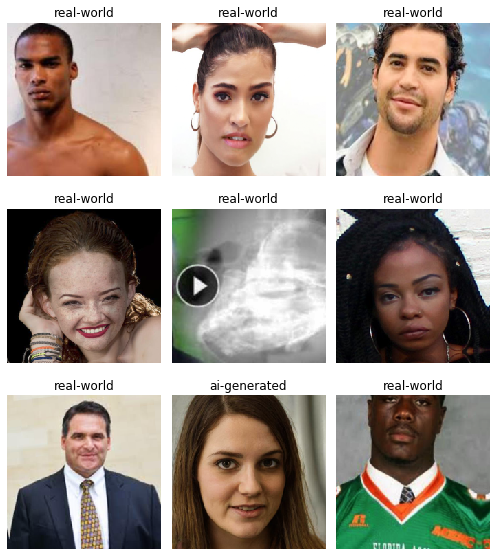

In [5]:
data.show_batch(rows=3, figsize=(7,8))

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['ai-generated', 'real-world'], 2, 61076, 15269)

## Train model

In [38]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy])

In [39]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# STOP!!! .. if not wanting to train, but only load model.
STOP!! ..

In [10]:
learn.fit_one_cycle(4)

KeyboardInterrupt: 

In [11]:
from fastai.callbacks import SaveModelCallback

In [12]:
# Train with the callback function set to save weights every epoch
learn.fit_one_cycle(4, 
       callbacks=[SaveModelCallback(learn, every='epoch',  
                  monitor='accuracy', name='saved_net_at_epoch')])

In [13]:
learn.save('stage-1')

In [ ]:
# If training got interrupted, to resume:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate])

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Unfreeze the network
learn.unfreeze()

# Chane the <next_epoch#> into the epoch it should resume training
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-6), 
                    start_epoch=<next_epoch#>,
                    callbacks=[SaveModelCallback(learn, 
                    every='epoch', monitor='accuracy', 
                    name=<callback_save_file>)])

In [ ]:
learn.save('stage-1-resumed')

In [14]:
learn.unfreeze()

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:
# If the plot is not showing try to give a start and end learning rate
#learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

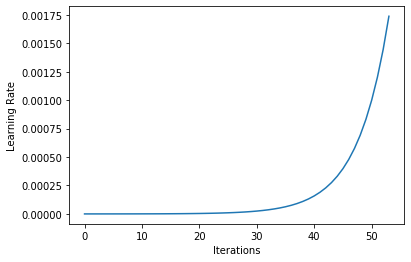

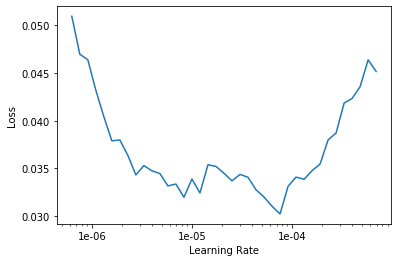

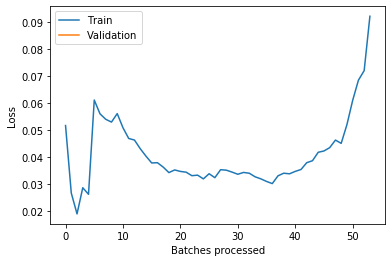

In [17]:
learn.recorder.plot_lr()
learn.recorder.plot()
learn.recorder.plot_losses()

In [19]:
#learn.fit_one_cycle(2, max_lr=slice(3e-6,3e-5))

learn.fit_one_cycle(2, max_lr=slice(3e-6,3e-5),
       callbacks=[SaveModelCallback(learn, every='epoch',  
                  monitor='accuracy', name='saved_net_at_epoch')])

In [ ]:
compared to first run:

In [20]:
learn.save('stage-2')

In [21]:
#learn.fit_one_cycle(2, max_lr=slice(3e-4,3e-3))

learn.fit_one_cycle(4, max_lr=slice(3e-6,3e-5),
       callbacks=[SaveModelCallback(learn, every='epoch',  
                  monitor='accuracy', name='saved_net_at_epoch')])

In [22]:
learn.save('stage-3')

In [12]:
learn.load('stage-3')

Learner(data=ImageDataBunch;

Train: LabelList (61076 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ai-generated,ai-generated,ai-generated,ai-generated,ai-generated
Path: data/faces/train;

Valid: LabelList (15269 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ai-generated,ai-generated,ai-generated,real-world,real-world
Path: data/faces/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [14]:
from fastai.callbacks import SaveModelCallback

In [15]:
learn.fit_one_cycle(4, max_lr=slice(3e-6,3e-5),
       callbacks=[SaveModelCallback(learn, every='epoch',  
                  monitor='accuracy', name='saved_net_at_epoch')])

In [16]:
learn.save('stage-4')

In [17]:
learn.fit_one_cycle(4, max_lr=slice(3e-6,3e-5),
       callbacks=[SaveModelCallback(learn, every='epoch',  
                  monitor='accuracy', name='saved_net_at_epoch')])

In [18]:
learn.save('stage-5')

## Interpretation

In [23]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (61076 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ai-generated,ai-generated,ai-generated,ai-generated,ai-generated
Path: data/faces/train;

Valid: LabelList (15269 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ai-generated,ai-generated,ai-generated,real-world,real-world
Path: data/faces/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

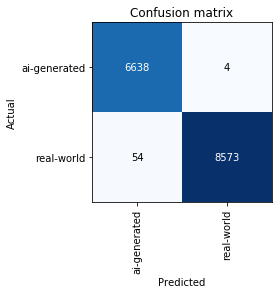

In [25]:
interp.plot_confusion_matrix()

In [13]:
tot=6638+8573+54+4; tot

15269

In [8]:
error2=(54+4)/tot; error2

0.0037985460737441877

In [26]:
interp.most_confused()

[('real-world', 'ai-generated', 54), ('ai-generated', 'real-world', 4)]

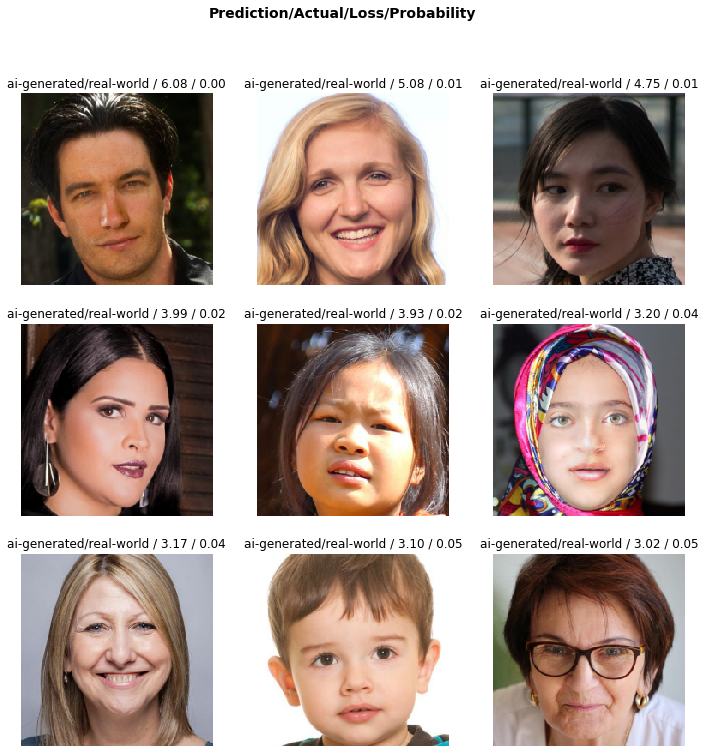

In [27]:
interp.plot_top_losses(9, figsize=(12,12))

In [28]:
learn.load('stage-3');

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

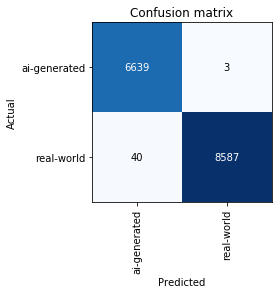

In [30]:
interp.plot_confusion_matrix()

In [31]:
interp.most_confused()

[('real-world', 'ai-generated', 40), ('ai-generated', 'real-world', 3)]

In [16]:
error3=(40+3)/tot; error3

0.0028161634684655185

In [10]:
error2

0.0037985460737441877

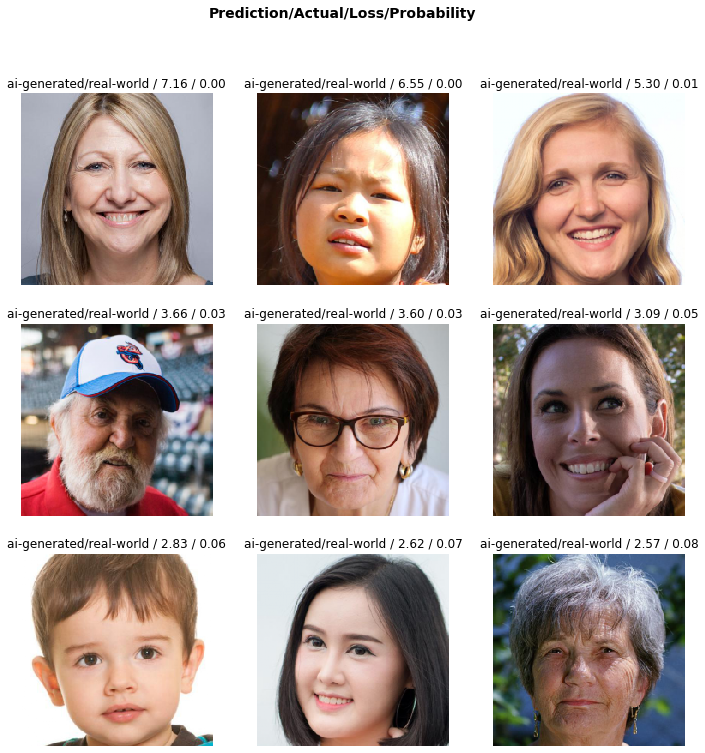

In [32]:
interp.plot_top_losses(9, figsize=(12,12))

In [19]:
learn.load('stage-4');

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

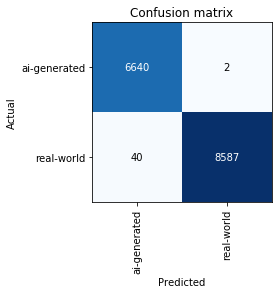

In [21]:
interp.plot_confusion_matrix()

In [22]:
interp.most_confused()

[('real-world', 'ai-generated', 40), ('ai-generated', 'real-world', 2)]

In [14]:
error4=(40+2)/tot; error4

0.0027506712947802736

In [17]:
error3

0.0028161634684655185

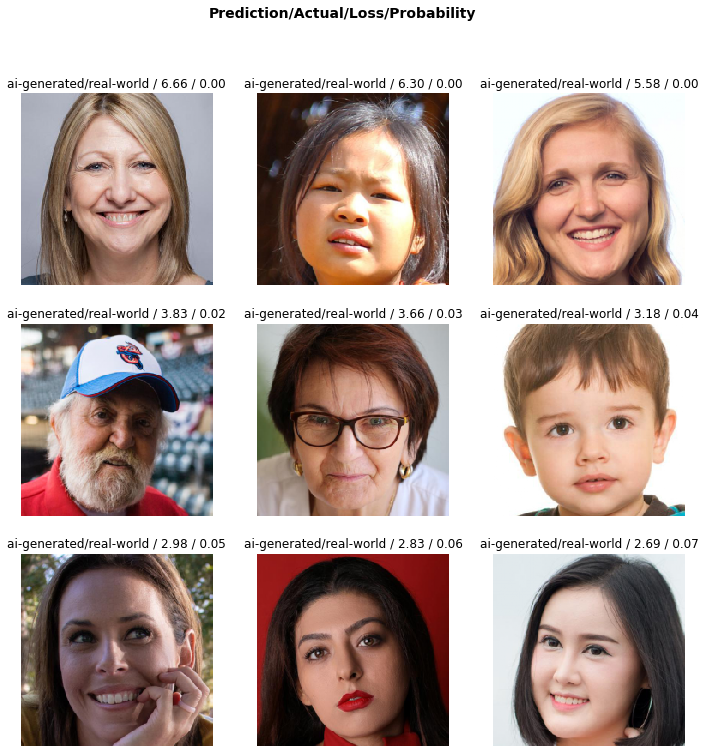

In [23]:
interp.plot_top_losses(9, figsize=(12,12))

In [24]:
learn.load('stage-5');

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

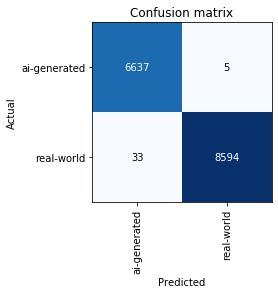

In [26]:
interp.plot_confusion_matrix()

In [27]:
interp.most_confused()

[('real-world', 'ai-generated', 33), ('ai-generated', 'real-world', 5)]

In [18]:
error5=(33+5)/tot; error5

0.0024887026000392953

In [19]:
error4

0.0027506712947802736

In [21]:
correct5=1-error5; correct5

0.9975112973999607

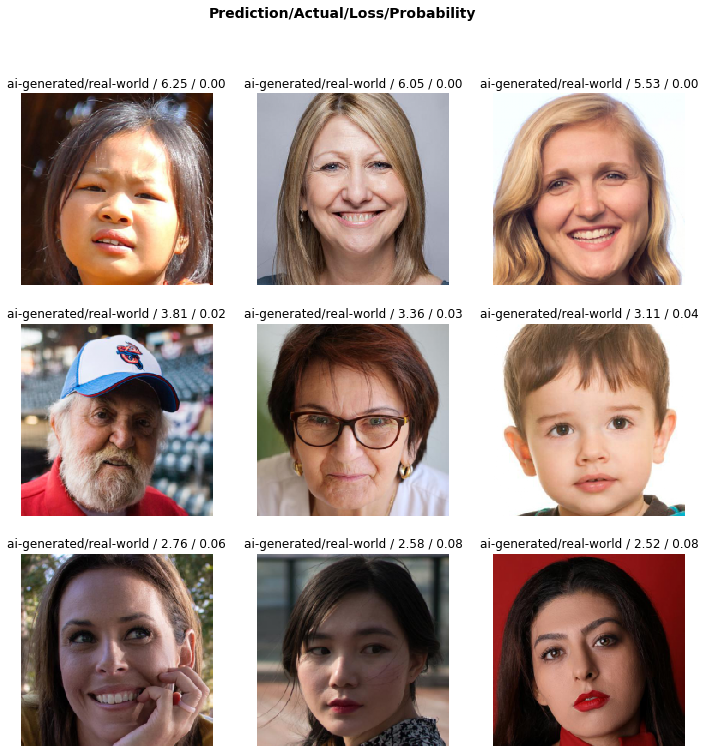

In [28]:
interp.plot_top_losses(9, figsize=(12,12))

# Verification with Testdata 

In [32]:
learn.load('stage-3')

Learner(data=ImageDataBunch;

Train: LabelList (61076 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ai-generated,ai-generated,ai-generated,ai-generated,ai-generated
Path: data/faces/train;

Valid: LabelList (15269 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ai-generated,ai-generated,ai-generated,real-world,real-world
Path: data/faces/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [8]:
data.test_ds

In [9]:
path = Path('data/faces/')

In [10]:
path_testdata = Path('data/faces/test')

In [11]:
# folder name ai-generated is NOT ai-generated.
# naming only for convinience to use the same code.
# name should be 'fake' OR 'photoshopped'
classes = ['ai-generated','real-world'] 

In [37]:
for c in classes:
    print(c)
    verify_images(path_testdata/c, delete=True, max_size=500)

ai-generated


real-world


In [33]:
path

PosixPath('data/faces')

In [34]:
path_testdata

PosixPath('data/faces/test')

In [12]:
tfms=get_transforms()
data_test = ImageDataBunch.from_folder(path, train='train', valid='test',
        ds_tfms=tfms, size=224, num_workers=4, bs=32).normalize(imagenet_stats)

### Verification with 10 000 ai-generated images of model 'stage2'

In [42]:
learn.validate(data_test.valid_dl)
# print out: loss, % wrong, % correct answer

[0.0032057557, tensor(0.0007), tensor(0.9993)]

In [43]:
learn.save('stage-2-test')

In [44]:
learn.data=data_test

In [45]:
interp = ClassificationInterpretation.from_learner(learn)

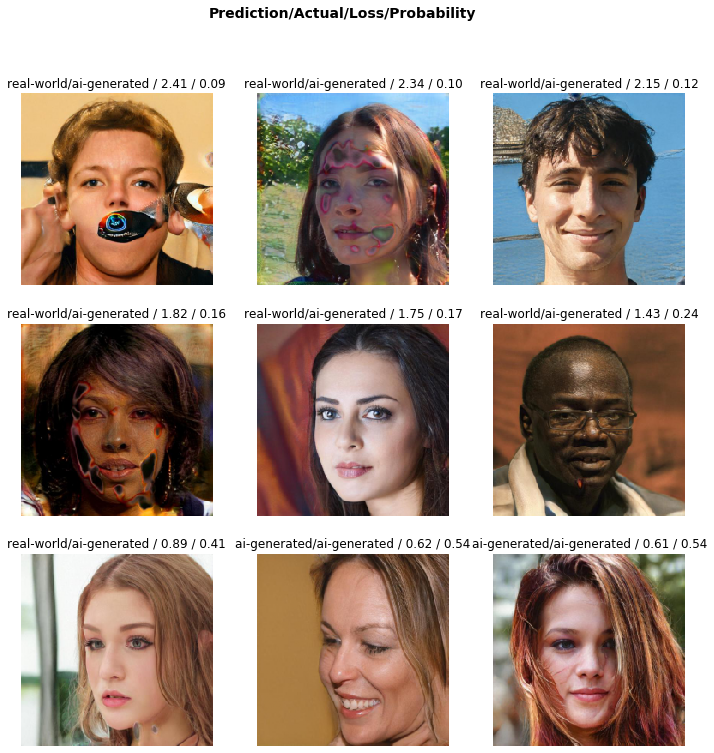

In [46]:
interp.plot_top_losses(9, figsize=(12,12))

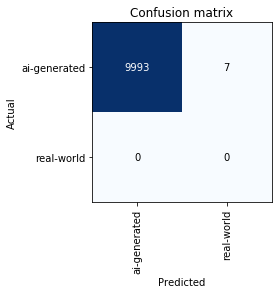

In [47]:
interp.plot_confusion_matrix()

In [48]:
interp.most_confused()

[('ai-generated', 'real-world', 7)]

In [12]:
tot=9993+7; tot

10000

In [13]:
correct = (9993)/tot; correct

0.9993

In [14]:
confused=(7)/tot; confused

0.0007

### Verification with 30 000 ai-generated +  202 000 real-world images

In [36]:
learn.validate(data_test.valid_dl)
# print out: loss, % wrong, % correct answer

[0.00049477053, tensor(0.0001), tensor(0.9999)]

In [37]:
learn.save('stage-5-test')

In [13]:
learn.load('stage-5-test')

Learner(data=ImageDataBunch;

Train: LabelList (61076 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ai-generated,ai-generated,ai-generated,ai-generated,ai-generated
Path: data/faces/train;

Valid: LabelList (15269 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ai-generated,ai-generated,ai-generated,real-world,real-world
Path: data/faces/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [14]:
learn.data=data_test

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

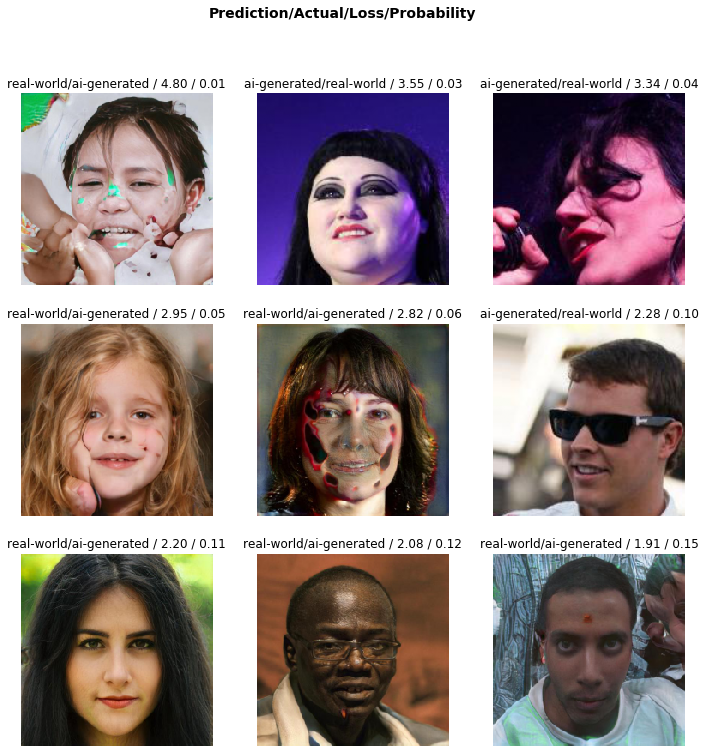

In [16]:
interp.plot_top_losses(9, figsize=(12,12))

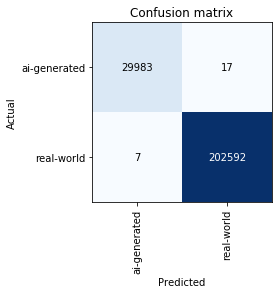

In [17]:
interp.plot_confusion_matrix()

In [18]:
interp.most_confused()

[('ai-generated', 'real-world', 17), ('real-world', 'ai-generated', 7)]

In [22]:
total=29983+202592+17+7; total

232599

In [23]:
correct = (29983+202592)/total; correct

0.9998968181290547

In [24]:
confused=(7+17)/total; confused

0.00010318187094527491

### Verification with 11 000 real-world  Flickr images of model 'stage-5'

In [40]:
learn.load('stage-5')

Learner(data=ImageDataBunch;

Train: LabelList (69876 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ai-generated,ai-generated,ai-generated,ai-generated,ai-generated
Path: data/faces/train;

Valid: LabelList (17469 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ai-generated,real-world,real-world,real-world,ai-generated
Path: data/faces/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [41]:
data.test_ds

In [42]:
path = Path('data/faces/')

In [43]:
path_testdata = Path('data/faces/test_flickr')

In [44]:
# folder name ai-generated is NOT ai-generated.
# naming only for convinience to use the same code.
# name should be 'fake' OR 'photoshopped'
classes = ['ai-generated','real-world'] 

In [45]:
for c in classes:
    print(c)
    verify_images(path_testdata/c, delete=True, max_size=500)

ai-generated
real-world


In [46]:
path

PosixPath('data/faces')

In [47]:
path_testdata

PosixPath('data/faces/test_flickr')

In [48]:
tfms=get_transforms()
data_test = ImageDataBunch.from_folder(path, train='train', valid='test_flickr',
        ds_tfms=tfms, size=224, num_workers=4, bs=32).normalize(imagenet_stats)

In [49]:
learn.validate(data_test.valid_dl)
# print out: loss, % wrong, % correct answer

[4.334799, tensor(0.7130), tensor(0.2870)]

In [50]:
learn.save('stage-5-test_flickr')

In [13]:
learn.load('stage-5-test')

Learner(data=ImageDataBunch;

Train: LabelList (61076 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ai-generated,ai-generated,ai-generated,ai-generated,ai-generated
Path: data/faces/train;

Valid: LabelList (15269 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ai-generated,ai-generated,ai-generated,real-world,real-world
Path: data/faces/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [51]:
learn.data=data_test

In [52]:
interp = ClassificationInterpretation.from_learner(learn)

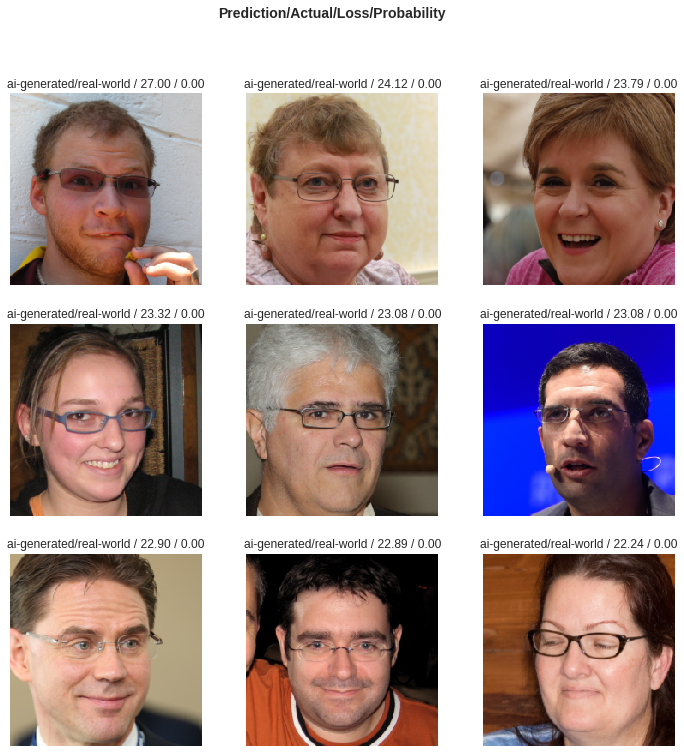

In [53]:
interp.plot_top_losses(9, figsize=(12,12))

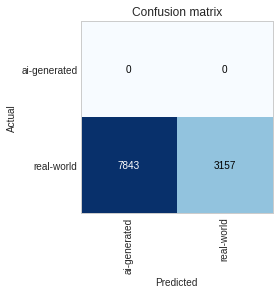

In [54]:
interp.plot_confusion_matrix()

In [55]:
interp.most_confused()

[('real-world', 'ai-generated', 7843)]

In [56]:
total=7843+3157; total

11000

In [57]:
correct = (3157)/total; correct

0.287

In [58]:
confused=(7843)/total; confused

0.713

## Accuracy Comparison

In [25]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

In [26]:
accuracy=[0.981924, 0.990504, 0.991093, 0.991093, 
          0.992141, 0.995088, 0.996201, 0.996070, 
          0.996725, 0.997446, 0.997184, 0.997249, 
          0.997315, 0.997380, 0.997249, 0.997249,
          0.997446, 0.997446, 0.997511]

Text(0, 0.5, 'accuracy')

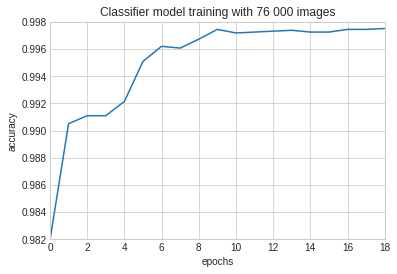

In [32]:
fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(accuracy)), accuracy)

plt.axis([0, 18, 0.982, 0.998])
plt.title("Classifier model training with 76 000 images")
plt.xlabel("epochs")
plt.ylabel("accuracy")

[0, 18, 0.99, 0.998]

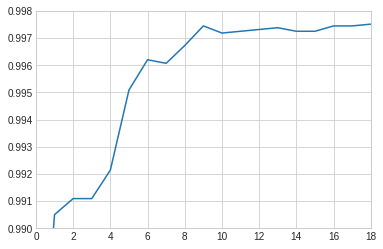

In [28]:
fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(accuracy)), accuracy)

plt.axis([0, 18, 0.990, 0.998])

[0, 18, 0.996, 0.998]

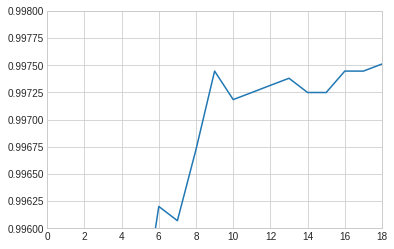

In [29]:
fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(accuracy)), accuracy)

plt.axis([0, 18, 0.996, 0.998])

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [ ]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In order to clean the entire set of images, we need to create a new dataset without the split. The video lecture demostrated the use of the `ds_type` param which no longer has any effect. See [the thread](https://forums.fast.ai/t/duplicate-widget/30975/10) for more details.

In [ ]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [ ]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

# db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
#                    .split_none()
#                    .label_from_df()
#                    .transform(get_transforms(), size=224)
#                    .databunch()
#      )

Then we create a new learner to use our new databunch with all the images.

In [ ]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

Make sure you're running this notebook in Jupyter Notebook, not Jupyter Lab. That is accessible via [/tree](/tree), not [/lab](/lab). Running the `ImageCleaner` widget in Jupyter Lab is [not currently supported](https://github.com/fastai/fastai/issues/1539).

In [ ]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.
ImageCleaner(ds, idxs, path)


If the code above does not show any GUI(contains images and buttons) rendered by widgets but only text output, that may caused by the configuration problem of ipywidgets. Try the solution in this [link](https://github.com/fastai/fastai/issues/1539#issuecomment-505999861) to solve it.


Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

Make sure to recreate the databunch and `learn_cln` from the `cleaned.csv` file. Otherwise the file would be overwritten from scratch, losing all the results from cleaning the data from toplosses.

In [ ]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

In [ ]:
ImageCleaner(ds, idxs, path, duplicates=True)

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [ ]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
defaults.device = torch.device('cpu')

In [ ]:
img = open_image(path/'black'/'00000021.jpg')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [ ]:
learn = load_learner(path)

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(1, max_lr=0.5)

### Learning rate (LR) too low

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-5)

In [ ]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [ ]:
learn.fit_one_cycle(1)

### Too many epochs

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))